### Script to
1. Classify common pairs using property of the curves, area,dtw between curves and save in respective folders (lot of thresholds; hence dont use)
2. Create drug, CL and tissue maps to see what %age of dr/CL/ti per class

###### **NOTE: this script used dose response files in the old format : cl,dr have dataset specific names, 1 row for 1 pair not 1 doasge

In [1]:
__author__ = 'Aanchal'

In [2]:
import pandas as pd
import pickle 
import matplotlib.pyplot as plt

import numpy as np
import similaritymeasures

import pickle 
import matplotlib.pyplot as plt

import FUNCTIONS as ff
import pickle


### print out common drug-target pairs between CCLE and GDSE

In [3]:
with open("../data_processed/Objects/CCLE_doseResponses.obj","rb") as f:
    names_ccle=pickle.load(f)
    response_ccle=pickle.load( f)
    logDosage_ccle=pickle.load( f)  
    
with open("../data_processed/Objects/GDSC_doseResponses.obj","rb") as f:
    names_gdsc=pickle.load(f)
    response_gdsc=pickle.load( f)
    logDosage_gdsc=pickle.load( f)    
    
common_CL_info = pd.read_excel('../data/drug_response/GDSC-CCLE-CTRP_conversion.xlsx', sheetname='Cell lines')
common_DR_info = pd.read_excel('../data/drug_response/GDSC-CCLE-CTRP_conversion.xlsx', sheetname='Drugs_edited')

Intersection=ff.getCommonPairs_CCLEnomenclature(names_ccle,names_gdsc, common_CL_info,common_DR_info)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\util\_decorators.py:188: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)


In [4]:
#Intersection=pd.read_csv("Files/Intersection.csv")
Intersection=pd.read_csv('../data_processed/CurveCategoryDetection/Intersection_withCurveCategory_SplitNormalUsingIC50.csv') #has curve categories from ccle and gdsc

print("No of common cell lines: "+str(len(set(Intersection.values[:,0]))))
print("No of common drugs: "+str(len(set(Intersection.values[:,1]))))
print("No of common pairs: "+str(len((Intersection.values))))

No of common cell lines: 357
No of common drugs: 15
No of common pairs: 3004


In [5]:
# To keep count of cell-lines, drugs and tissue in each class
clnames=Intersection.values[:,0]
drnames=Intersection.values[:,1]
cl_set=(list(sorted(set( clnames ) )))
dr_set=(list(sorted(set( drnames ) )))

gdsc_cell_line_tissue =pd.read_csv("../data/drug_response/GDSC/GDSC_tissue_info(1).csv")
ccle_cell_line_tissue =pd.read_excel("../data/drug_response/CCLE/CCLE_sample_info_file_2012-10-18_edited.xlsx",sheetname="CCLE_sample_tissue")
cell_line_tissue=ccle_cell_line_tissue 
    

tissueType=[]
for i in range(len(cl_set)):
    ind=np.where(cell_line_tissue.values[:,0]==cl_set[i] )[0]
    tissueType.append( cell_line_tissue.values[ ind , 1 ][0] )
#print(np.where( set(tissueType) == 'nan'))

#remove nan
#tissueType = [x for x in tissueType if x == x]
#print(set(cleanedList ) )
ti_set=list(sorted( set(tissueType) ) )
print(ti_set)





drug_map=pd.DataFrame()
cl_map=pd.DataFrame()
ti_map=pd.DataFrame()

drug_map['DRUG_NAME'] = dr_set
cl_map['CL_NAME'] = cl_set
ti_map['TISSUE_NAME'] = ti_set #tissue map

for i in range(5):
    
    drug_map['C'+str(i+1)] = [0]*len(dr_set)
    cl_map['C'+str(i+1)] = [0]*len(cl_set)
    ti_map['C'+str(i+1)] = [0]*len(ti_set)

drug_map['#cl_tested'] = [0]*len(dr_set)
cl_map['#dr_tested'] = [0]*len(cl_set)
ti_map['#dr_tested'] = [0]*len(ti_set)

['autonomic_ganglia', 'biliary_tract', 'bone', 'breast', 'central_nervous_system', 'endometrium', 'haematopoietic_and_lymphoid_tissue', 'kidney', 'large_intestine', 'liver', 'lung', 'oesophagus', 'ovary', 'pancreas', 'pleura', 'prostate', 'salivary_gland', 'skin', 'soft_tissue', 'stomach', 'thyroid', 'upper_aerodigestive_tract', 'urinary_tract']


In [6]:
def getIndexInDataset(names,cl,dr):
    a=names.index[   names['Cell_line_name']==cl ]
    b=names.index[   names['Drug _Name']==dr]
    return names.index[a & b][0]

def getCurveSimilarities(x_ccle,y_ccle,x_gdse,y_gdse):
    exp_data = np.zeros((8, 2))
    num_data = np.zeros((9, 2))
    
    exp_data[:, 0] = x_ccle
    exp_data[:, 1] = y_ccle
    num_data[:, 0] = x_gdse
    num_data[:, 1] = y_gdse
    
    # quantify the difference between the two curves using area between two curves
    area = similaritymeasures.area_between_two_curves(exp_data, num_data)
    # quantify the difference between the two curves using Dynamic Time Warping distance
    dtw, d = similaritymeasures.dtw(exp_data, num_data)
    
    return (area,dtw)

def classifyPairs(cl, dr, ccle_label,gdsc_label,x_ccle,y_ccle,x_gdsc,y_gdsc,area, dtw,drug_map,cl_map,ti_map):
    
    drug_id=dr_set.index(dr)
    cl_id=cl_set.index(cl)
    ind=np.where(cell_line_tissue.values[:,0]==cl )[0]
    #print(names.values[i,0],ind,cell_line_tissue.values[ ind , 1 ])
    ti_id=ti_set.index( cell_line_tissue.values[ ind , 1 ]  )
   

    
    if(ccle_label==gdsc_label):
        
        if(area<150 and dtw<150):
            a=1
            #print(cl,dr, drug_id,1+drug_map.loc[drug_id,'C1'])
            drug_map.set_value( drug_id ,'C1', 1+drug_map.loc[drug_id,'C1'])
            cl_map.set_value( cl_id ,'C1', 1+cl_map.loc[cl_id,'C1'])
            ti_map.set_value( ti_id ,'C1', 1+ti_map.loc[ti_id,'C1'])
            #plt.savefig("../figures/CommonCurvesClassification_method1/CONCORDANT/"+str(cl) + "-" +str(dr)+".png") #238 with th=100, 751 with 150
     
        elif(  abs(x_ccle[0]-x_gdsc[0] )>=3  or abs(x_ccle[-1]-x_gdsc[-1])>=3 ):
            a=1#
            drug_map.set_value( drug_id ,'C2', 1+drug_map.loc[drug_id,'C2'])
            cl_map.set_value( cl_id ,'C2', 1+cl_map.loc[cl_id,'C2'])
            ti_map.set_value( ti_id ,'C2', 1+ti_map.loc[ti_id,'C2'])
            #plt.savefig(../figures/CommonCurvesClassification_method1/CONCORDANT_DIFFRANGE/"+str(cl) + "-" +str(dr)+".png")
 
        elif(  sum(n > 1 for n in np.subtract(y_ccle,y_gdsc[0:8])  )>=7 or sum(n > 1 for n in np.subtract(y_gdsc[0:8],y_ccle)  )>=7 ) :
            a=1#
            drug_map.set_value( drug_id ,'C4', 1+drug_map.loc[drug_id,'C4'])
            cl_map.set_value( cl_id ,'C4', 1+cl_map.loc[cl_id,'C4'])
            ti_map.set_value( ti_id ,'C4', 1+ti_map.loc[ti_id,'C4'])
            #plt.savefig("../figures/CommonCurvesClassification_method1/SHIFTED/"+str(cl) + "-" +str(dr)+".png") #331 with th=0, 257 with th=1,751 with nnz>7
        #elif(  check_gt0not(list((np.subtract(y_ccle,y_gdsc[0:8])) ),1) or check_gt0not(list((np.subtract(y_gdsc[0:8],y_ccle)) ),1) ) :
        elif(area<250 and dtw<150):
            a=1#
            drug_map.set_value( drug_id ,'C3', 1+drug_map.loc[drug_id,'C3'])
            cl_map.set_value( cl_id ,'C3', 1+cl_map.loc[cl_id,'C3'])
            ti_map.set_value( ti_id ,'C3', 1+ti_map.loc[ti_id,'C3'])
            #plt.savefig("../figures/CommonCurvesClassification_method1/CONCORDANT_LESSCONFIDENCE/"+str(cl) + "-" +str(dr)+".png") #238 with th=100, 751 with 150

        else:
            a=1#
            drug_map.set_value( drug_id ,'C5', 1+drug_map.loc[drug_id,'C5'])
            cl_map.set_value( cl_id ,'C5', 1+cl_map.loc[cl_id,'C5'])
            ti_map.set_value( ti_id ,'C5', 1+ti_map.loc[ti_id,'C5'])
            #plt.savefig("../figures/CommonCurvesClassification_method1/CONTRADICTORY/"+str(cl) + "-" +str(dr)+".png")
            
    elif(  (ccle_label==1 and gdsc_label==2) or   (ccle_label==2 and gdsc_label==1)  ) :
        
        if((area<200 and dtw<150) and ( abs(x_ccle[0]-x_gdsc[0] )>=3  or abs(x_ccle[-1]-x_gdsc[-1])>=3)  ):
            drug_map.set_value( drug_id ,'C2', 1+drug_map.loc[drug_id,'C2'])
            cl_map.set_value( cl_id ,'C2', 1+cl_map.loc[cl_id,'C2'])
            ti_map.set_value( ti_id ,'C2', 1+ti_map.loc[ti_id,'C2'])
            #plt.savefig("../figures/CommonCurvesClassification_method1/CONCORDANT_DIFFRANGE/"+str(cl) + "-" +str(dr)+".png")
        elif ( ( dtw<150) and ( sum(n > 1 for n in np.subtract(y_ccle,y_gdsc[0:8])  )>=6 or sum(n > 1 for n in np.subtract(y_gdsc[0:8],y_ccle)  )>=6 )):
            drug_map.set_value( drug_id ,'C4', 1+drug_map.loc[drug_id,'C4'])
            cl_map.set_value( cl_id ,'C4', 1+cl_map.loc[cl_id,'C4'])
            ti_map.set_value( ti_id ,'C4', 1+ti_map.loc[ti_id,'C4'])
            #plt.savefig("../figures/CommonCurvesClassification_method1/SHIFTED/"+str(cl) + "-" +str(dr)+".png")       
        else:
            drug_map.set_value( drug_id ,'C5', 1+drug_map.loc[drug_id,'C5'])
            cl_map.set_value( cl_id ,'C5', 1+cl_map.loc[cl_id,'C5'])
            ti_map.set_value( ti_id ,'C5', 1+ti_map.loc[ti_id,'C5'])
            #plt.savefig("../figures/CommonCurvesClassification_method1/CONTRADICTORY/"+str(cl) + "-" +str(dr)+".png")
    else:
        drug_map.set_value( drug_id ,'C5', 1+drug_map.loc[drug_id,'C5'])
        cl_map.set_value( cl_id ,'C5', 1+cl_map.loc[cl_id,'C5'])
        ti_map.set_value( ti_id ,'C5', 1+ti_map.loc[ti_id,'C5'])
        #plt.savefig("../figures/CommonCurvesClassification_method1/CONTRADICTORY/"+str(cl) + "-" +str(dr)+".png")

    return (drug_map,cl_map,ti_map)   

def check_gt0not(list1, val): 
    for x in list1: 
        if val>= x: 
            return False 
    return True


In [7]:
ar_l=[]
dtw_l=[]
for i in range(len(Intersection)):
    
    print(i)

    cl=Intersection.values[i,0]
    dr=Intersection.values[i,1]
    ccle_label=Intersection.values[i,2]
    gdsc_label=Intersection.values[i,3]
    
    
    ind1=getIndexInDataset(names_ccle,cl, dr)  
    ind2=getIndexInDataset(names_gdsc,cl,dr)   
    
    #print(cl,dr, logDosage_ccle.values[ind1, 0:8],response_ccle.values[ind1, 0:8])
    [area,dtw] = getCurveSimilarities(logDosage_ccle.values[ind1, 0:8],response_ccle.values[ind1, 0:8],logDosage_gdsc.values[ind2, 0:9],response_gdsc.values[ind2, 0:9])
    
    ar_l.append(area);
    dtw_l.append(dtw);
    
    '''plt.figure();
    plt.title(names_ccle.values[ind1, 0] +" : "+names_ccle.values[ind1, 1]+"\n"+str(response_ccle.values[ind1, 0:8].astype(int)) +","+str(response_gdsc.values[ind2,0:9].astype(int)) +" \n"+str( )+","+","+str(area.round())+","+","+str(dtw.round()) )
    plt.scatter(logDosage_ccle.values[ind1, 0:8], response_ccle.values[ind1, 0:8], color='k')
    plt.scatter(logDosage_gdsc.values[ind2, 0:9], response_gdsc.values[ind2, 0:9], color='g')
    plt.ylim(-100,50)'''
    
    
    
    drug_map,cl_map,ti_map=classifyPairs(cl, dr, ccle_label,gdsc_label,logDosage_ccle.values[ind1, 0:8],response_ccle.values[ind1, 0:8],logDosage_gdsc.values[ind2, 0:9],response_gdsc.values[ind2, 0:9],area, dtw,drug_map,cl_map,ti_map)
    
    drug_id=dr_set.index(dr)
    cl_id=cl_set.index(cl)
    ind=np.where(cell_line_tissue.values[:,0]==cl )[0]
    ti_id=ti_set.index( cell_line_tissue.values[ ind , 1 ]  )

    # this code can be out of loop in a separate loop iterating dr and cl set!
    dr_freq=len(Intersection[ Intersection['Drug _Name']== dr ])
    cl_freq=len(Intersection[ Intersection['Cell_line_name']== cl ])

    drug_map.set_value( drug_id ,'#cl_tested', dr_freq)
    cl_map.set_value( cl_id ,'#dr_tested', cl_freq)
    ti_map.set_value( ti_id ,'#dr_tested', cl_freq+ti_map.loc[ti_id,'#dr_tested'])
   
    
    #plt.show()

0
1
2
3
4
5
6


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:88: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:89: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:90: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
C:\ProgramData\Anaconda3\lib\s

7
8
9
10
11
12
13

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:58: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
C:\ProgramData\Anaconda3\lib\s


14
15
16
17
18
19
20

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:73: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:74: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:75: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead



21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95


C:\ProgramData\Anaconda3\lib\site-packages\similaritymeasures\similaritymeasures.py:95: RuntimeWarning: invalid value encountered in greater_equal
  crossTF = cross >= 0
C:\ProgramData\Anaconda3\lib\site-packages\similaritymeasures\similaritymeasures.py:99: RuntimeWarning: invalid value encountered in less_equal
  crossTF = cross <= 0


96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346


1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084
2085
2086
2087
2088
2089
2090
2091
2092
2093
2094
2095
2096
2097
2098
2099
2100
2101
2102
2103
2104
2105
2106
2107
2108
2109
2110
2111
2112
2113
2114
2115
2116
2117


In [8]:
for i in range(5):    
    drug_map[['C'+str(i+1)+'%']] = (100*drug_map[['C'+str(i+1)]].div(drug_map['#cl_tested'].values,axis=0)).round(2)
    cl_map[['C'+str(i+1)+'%']] = (100*cl_map[['C'+str(i+1)]].div(cl_map['#dr_tested'].values,axis=0)).round(2)
    ti_map[['C'+str(i+1)+'%']] = (100*ti_map[['C'+str(i+1)]].div(ti_map['#dr_tested'].values,axis=0)).round(2)

drug_map=pd.DataFrame( drug_map.sort_values('C5%',ascending=False) )
cl_map=pd.DataFrame( cl_map.sort_values('C5%',ascending=False) )
ti_map=pd.DataFrame( ti_map.sort_values('C5%',ascending=False) )



C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


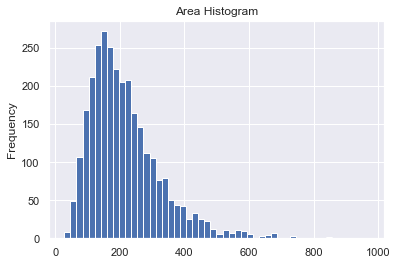

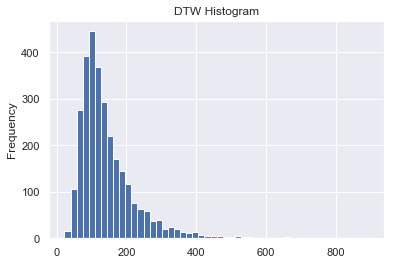

In [9]:

plt.hist(ar_l, bins=50)
plt.gca().set(title='Area Histogram', ylabel='Frequency');
plt.show()

plt.hist(dtw_l, bins=50)
plt.gca().set(title='DTW Histogram', ylabel='Frequency');

In [10]:
853+931+409+632+897

3722

In [11]:
drug_map

,DRUG_NAME,C1,C2,C3,C4,C5,#cl_tested,C1%,C2%,C3%,C4%,C5%
13,Sorafenib,27,0,14,10,56,107,25.23,0.00,13.08,9.35,52.34
5,Nilotinib,68,0,32,37,116,253,26.88,0.00,12.65,14.62,45.85
14,TAE684,29,0,21,12,49,111,26.13,0.00,18.92,10.81,44.14
9,PF2341066,39,0,14,11,47,111,35.14,0.00,12.61,9.91,42.34
4,Lapatinib,46,0,10,13,35,104,44.23,0.00,9.62,12.50,33.65
2,AZD6244,90,0,58,61,105,314,28.66,0.00,18.47,19.43,33.44
1,AZD0530,53,0,7,14,37,111,47.75,0.00,6.31,12.61,33.33
8,PD-0332991,46,0,35,100,90,271,16.97,0.00,12.92,36.90,33.21
10,PHA-665752,55,0,10,10,36,111,49.55,0.00,9.01,9.01,32.43
3,Erlotinib,44,0,11,13,29,97,45.36,0.00,11.34,13.40,29.90


In [14]:
cl_map

,CL_NAME,C1,C2,C3,C4,C5,#dr_tested,C1%,C2%,C3%,C4%,C5%
47,DAOY_CENTRAL_NERVOUS_SYSTEM,0,0,0,0,1,1,0.00,0.00,0.00,0.00,100.00
18,AN3CA_ENDOMETRIUM,0,0,0,0,1,1,0.00,0.00,0.00,0.00,100.00
351,VMRCRCW_KIDNEY,0,0,0,0,1,1,0.00,0.00,0.00,0.00,100.00
123,JHH6_LIVER,0,0,0,0,1,1,0.00,0.00,0.00,0.00,100.00
186,MKN45_STOMACH,0,0,0,0,1,1,0.00,0.00,0.00,0.00,100.00
344,U2OS_BONE,0,0,0,0,1,1,0.00,0.00,0.00,0.00,100.00
323,SW1990_PANCREAS,0,0,0,0,1,1,0.00,0.00,0.00,0.00,100.00
327,SW900_LUNG,0,0,0,0,4,4,0.00,0.00,0.00,0.00,100.00
55,DU145_PROSTATE,0,0,0,1,6,7,0.00,0.00,0.00,14.29,85.71
205,NCIH1693_LUNG,0,1,0,0,6,7,0.00,14.29,0.00,0.00,85.71


In [15]:
ti_map

,TISSUE_NAME,C1,C2,C3,C4,C5,#dr_tested,C1%,C2%,C3%,C4%,C5%
15,prostate,1,2,1,3,13,134,0.75,1.49,0.75,2.24,9.70
5,endometrium,7,20,3,7,19,426,1.64,4.69,0.70,1.64,4.46
0,autonomic_ganglia,12,15,5,8,33,761,1.58,1.97,0.66,1.05,4.34
13,pancreas,28,44,7,14,40,937,2.99,4.70,0.75,1.49,4.27
7,kidney,4,10,3,3,7,173,2.31,5.78,1.73,1.73,4.05
8,large_intestine,38,34,14,15,75,1900,2.00,1.79,0.74,0.79,3.95
9,liver,16,24,5,8,17,440,3.64,5.45,1.14,1.82,3.86
22,urinary_tract,13,15,5,3,12,318,4.09,4.72,1.57,0.94,3.77
18,soft_tissue,12,17,7,8,24,674,1.78,2.52,1.04,1.19,3.56
19,stomach,13,24,3,11,21,590,2.20,4.07,0.51,1.86,3.56
